# Regression Time Series

## Import Library

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.2 MB/s eta 0:00:00


## Import Data

In [5]:
df_customer = pd.read_csv('Customer.csv', sep=';')
df_product = pd.read_csv('Product.csv', sep=';')
df_store = pd.read_csv('Store.csv', sep=';')
df_transaction = pd.read_csv('Transaction.csv', sep=';')

## Data Preparation

In [6]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [7]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [8]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [9]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [10]:
#convert type object to float
df_customer['Income'] = df_customer['Income'].str.replace(',', '.').astype(float)

In [11]:
#fill missing values
df_customer.isna().sum()
df_customer.fillna(method='ffill', inplace=True)

In [12]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [13]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [14]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [15]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [16]:
#convert Date to datetime
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format='%d/%m/%Y')

In [17]:
#merge df
merged_df = pd.merge(df_transaction, df_product, on='ProductID', how='left')
merged_df = pd.merge(merged_df, df_store, on='StoreID', how='left')
merged_df = pd.merge(merged_df, df_customer, on='CustomerID', how='left')
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,10000,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,10000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,Married,6.95


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   Price_y         5020 non-null   int64         
 10  StoreName       5020 non-null   object        
 11  GroupStore      5020 non-null   object        
 12  Type            5020 non-null   object        
 13  Latitude        5020 non-null   object        
 14  Longitude       5020 non-null   object        
 15  Age 

In [19]:
(merged_df['Price_x']/merged_df['Price_y']).value_counts()

1.0    5020
dtype: int64

Column Price_x and Price_y have a same value in each column, so one of the column can be drop

In [20]:
merged_df.drop(columns = 'Price_y', inplace=True)

In [21]:
data = merged_df
data.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",36,0,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666",44,1,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",27,1,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",48,1,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,Gita Ginara,Gita,General Trade,"-6,966667","110,416664",33,0,Married,6.95


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   StoreName       5020 non-null   object        
 10  GroupStore      5020 non-null   object        
 11  Type            5020 non-null   object        
 12  Latitude        5020 non-null   object        
 13  Longitude       5020 non-null   object        
 14  Age             5020 non-null   int64         
 15  Gend

In [23]:
#change data type from object to float
data['Longitude'] = data['Longitude'].apply(lambda x: x.replace(',','.')).astype(float)
data['Latitude'] = data['Latitude'].apply(lambda x: x.replace(',','.')).astype(float)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   StoreName       5020 non-null   object        
 10  GroupStore      5020 non-null   object        
 11  Type            5020 non-null   object        
 12  Latitude        5020 non-null   float64       
 13  Longitude       5020 non-null   float64       
 14  Age             5020 non-null   int64         
 15  Gend

In [25]:
df_reg = data.groupby('Date').agg({'Qty':'sum'})
df_reg

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

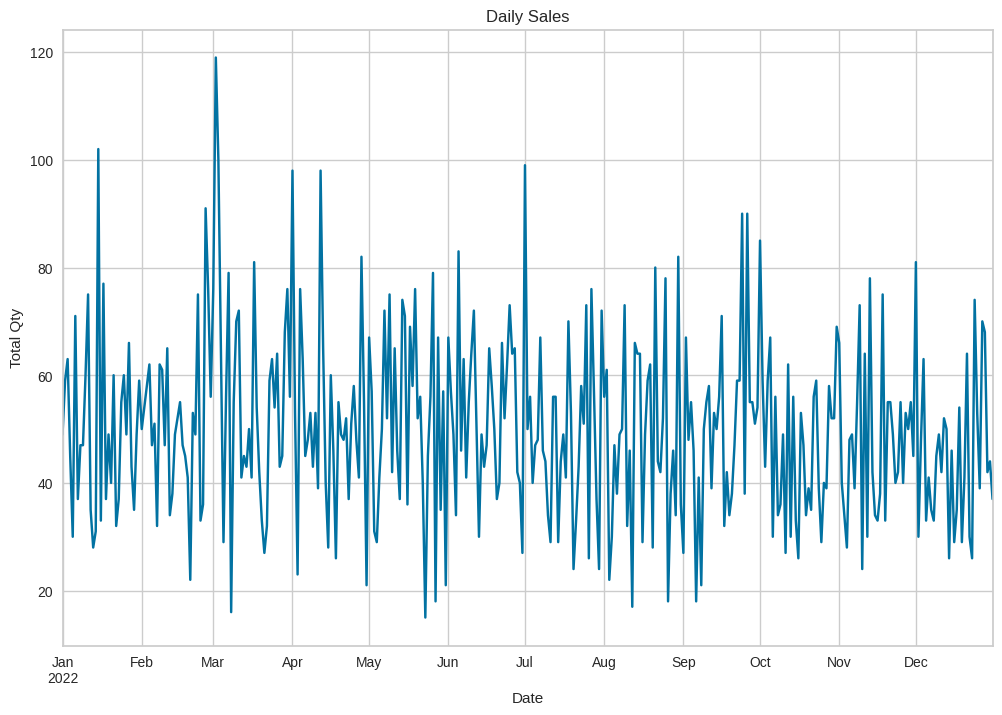

In [26]:
# plot qty sales in a year
df_reg.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [27]:
#Split Data Training and Testing
print(df_reg.shape)
test_size = round(df_reg.shape[0] * 0.15)
train = df_reg.iloc[:-1*(test_size)]
test = df_reg.iloc[-1*(test_size):]
print(train.shape, test.shape)

(365, 1)
(310, 1) (55, 1)


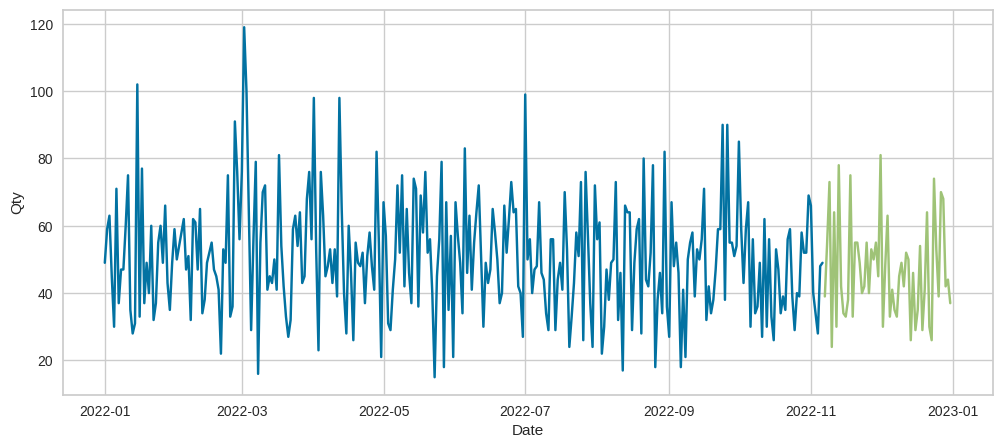

In [28]:
plt.figure(figsize=(12,5))
sns.lineplot(data=train, x=train.index, y=train['Qty'])
sns.lineplot(data=test, x=test.index, y=test['Qty'])
plt.show()

## Data Stationary Check

In [29]:
def adf_test(dataset):
    df_test = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ", df_test[0])
    print("2. P-Value : ", df_test[1])
    print("3. Num Of Lags : ", df_test[2])
    print("4. Num Of Observations Used For ADF Regression : ", df_test[3])
    print("5. Critical Values : ")
    for key, val in df_test[4].items():
      print("\t",key, ": ", val)
adf_test(df_reg)

1. ADF :  -19.448086319449082
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression :  364
5. Critical Values : 
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


P-Value (0.00) < Alpha (0.05) shows that the data is stationary and can be used in time series analysis with ARIMA

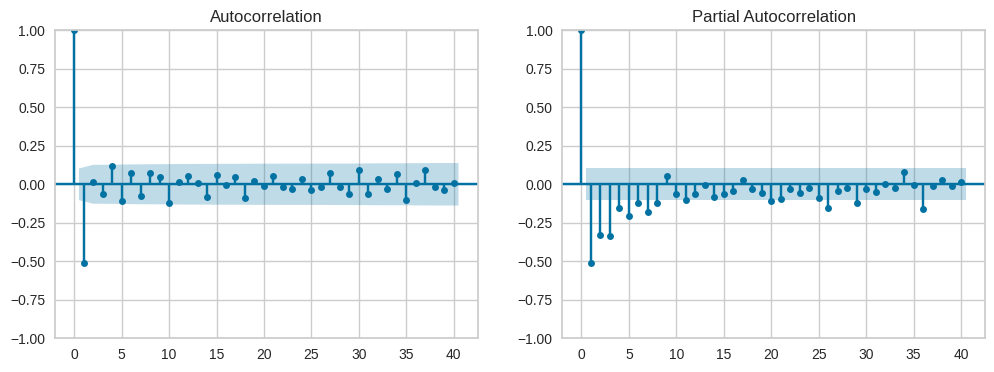

In [30]:
# ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_reg.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_reg.diff().dropna(), lags=40, ax=ax[1])
plt.show()

## Modelling

In [31]:
#auto-fit ARIMA
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Hyperparameter Tuning

In [32]:
from itertools import product

p = range(0, 4)
d = range(0, 4)
q = range(0, 4)

pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3)]


In [33]:
aic_scores = []
for param in pdq:
  model = ARIMA(df_reg, order=param)
  model_fit = model.fit()
  aic_scores.append({'par': param, 'aic': model_fit.aic})

best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (2, 1, 3), 'aic': 3087.8267552844973}


In [34]:
#hyperparameter tuning
model_hyper = ARIMA(train, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

### Manual Hyperparameter Tuning

In [35]:
#Trial and error tuning (40,2,9)
model_manual = ARIMA(train, order=(30,1,9))
model_fit_manual = model_manual.fit()

### Plot Forecasting

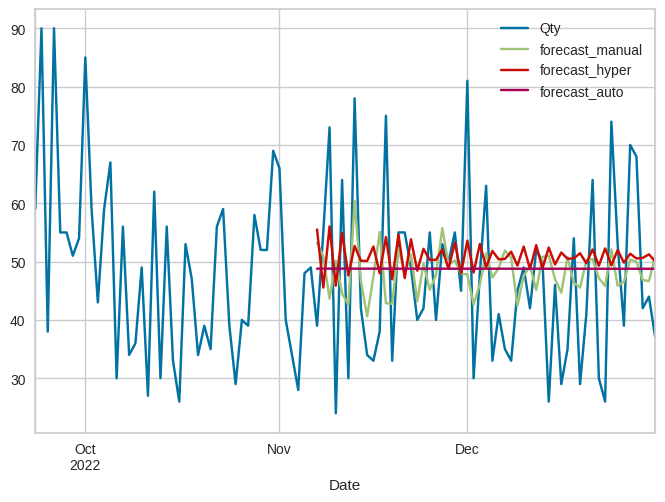

In [36]:
forecast_manual = model_fit_manual.forecast(len(test))
forecast_hyper = model_fit_hyper.forecast(len(test))
forecast_auto = auto_arima.predict(len(test))

df_plot = df_reg.iloc[-100:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(forecast_manual)) + list(forecast_manual)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_hyper)) + list(forecast_hyper)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

## Metrics Evaluation

In [37]:
#Manual parameter tuning metrics 10.9 , 0.24 , 14.07
mae_manual = mean_absolute_error(test, forecast_manual)
mape_manual = mean_absolute_percentage_error(test, forecast_manual)
rmse_manual = np.sqrt(mean_squared_error(test, forecast_manual))

print(f'mae_manual : {round(mae_manual,3)}')
print(f'mape_manual : {round(mape_manual,3)}')
print(f'rmse_manual : {round(rmse_manual,3)}')

mae_manual : 11.488
mape_manual : 0.276
rmse_manual : 14.106


In [38]:
#Hyperparameter parameter tuning metrics
mae_hyper = mean_absolute_error(test, forecast_hyper)
mape_hyper = mean_absolute_percentage_error(test, forecast_hyper)
rmse_hyper = np.sqrt(mean_squared_error(test, forecast_hyper))

print(f'mae_hyper : {round(mae_hyper,3)}')
print(f'mape_hyper : {round(mape_hyper,3)}')
print(f'rmse_mhyper : {round(rmse_hyper,3)}')

mae_hyper : 12.073
mape_hyper : 0.304
rmse_mhyper : 14.359


In [39]:
#Auto-fit ARIMA metrics
mae_auto = mean_absolute_error(test, forecast_auto)
mape_auto = mean_absolute_percentage_error(test, forecast_auto)
rmse_auto = np.sqrt(mean_squared_error(test, forecast_auto))

print(f'mae_auto : {round(mae_auto,3)}')
print(f'mape_auto : {round(mape_auto,3)}')
print(f'rmse_auto : {round(rmse_auto,3)}')

mae_auto : 12.055
mape_auto : 0.293
rmse_auto : 14.528


The best evaluation metrics with Manual Hyperparameter Tuning with order (30,1,9)

In [40]:
## Apply model with "Manual Hyperparameter Tuning" to forecast data

model = ARIMA(df_reg, order=(30,1,9))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [41]:
forecast

2023-01-01    51.303774
2023-01-02    52.541369
2023-01-03    48.613707
2023-01-04    42.010078
2023-01-05    56.231849
2023-01-06    39.574609
2023-01-07    48.781403
2023-01-08    43.774444
2023-01-09    51.849385
2023-01-10    45.351224
2023-01-11    44.674725
2023-01-12    42.842940
2023-01-13    37.599004
2023-01-14    52.587547
2023-01-15    35.220119
2023-01-16    46.139757
2023-01-17    49.942769
2023-01-18    47.822304
2023-01-19    39.883244
2023-01-20    46.422082
2023-01-21    48.714935
2023-01-22    36.412083
2023-01-23    55.463118
2023-01-24    49.340200
2023-01-25    45.349794
2023-01-26    47.544756
2023-01-27    50.099349
2023-01-28    44.732111
2023-01-29    40.707997
2023-01-30    53.229038
2023-01-31    47.322310
Freq: D, Name: predicted_mean, dtype: float64

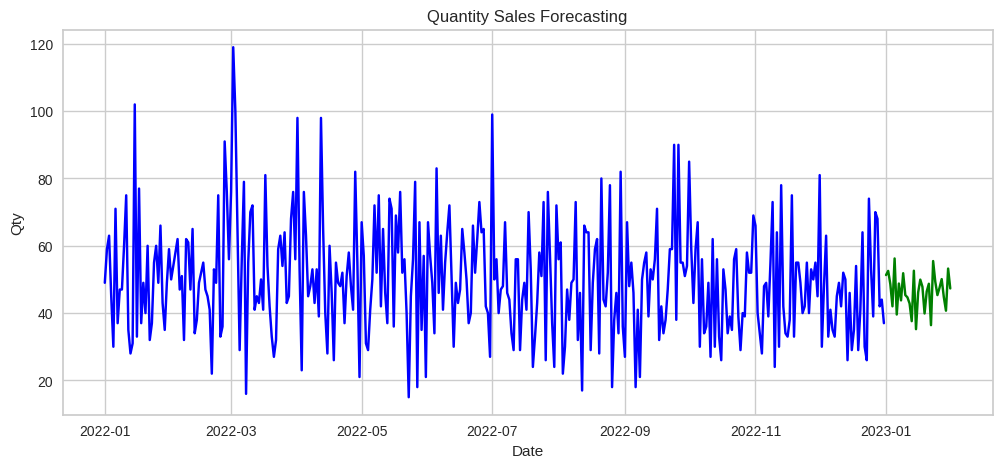

In [46]:
# Visualize Predictions
plt.figure(figsize=(12,5))
plt.plot(df_reg, color='blue')
plt.plot(forecast, color='green')
plt.title('Quantity Sales Forecasting')
plt.ylabel('Qty')
plt.xlabel('Date')
plt.show()

In [43]:
forecast.describe()

count    31.000000
mean     46.518775
std       5.416796
min      35.220119
25%      43.308692
50%      47.322310
75%      50.021059
max      56.231849
Name: predicted_mean, dtype: float64

# Clustering

In [107]:
merged_df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude,Age,Gender,Marital Status,Income
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,36,0,Married,10.53
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,Yoghurt,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,44,1,Married,14.58
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664,27,1,Single,0.18
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664,48,1,Married,12.57
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,Yoghurt,Gita Ginara,Gita,General Trade,-6.966667,110.416664,33,0,Married,6.95


In [108]:
merged_df.corr()

,CustomerID,Price_x,Qty,TotalAmount,StoreID,Latitude,Longitude,Age,Gender,Income
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,0.002278,-0.003122,-0.025952,-0.009947,0.005783
Price_x,-0.016423,1.000000,-0.353640,0.440632,-0.032863,-0.029008,0.018652,0.014693,0.010705,0.001196
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.004170,0.004807,-0.027768,-0.010542,-0.028425
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.029938,0.025437,-0.016900,-0.008774,-0.025350
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,0.471852,-0.094943,-0.003872,-0.000189,0.001613
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,1.000000,-0.395995,0.009266,-0.006051,0.015518
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,-0.395995,1.000000,0.015951,-0.001183,0.004385
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,0.009266,0.015951,1.000000,-0.033183,0.486692
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.006051,-0.001183,-0.033183,1.000000,-0.071443
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.015518,0.004385,0.486692,-0.071443,1.000000


In [109]:
df_cluster = merged_df.groupby('CustomerID').agg({'TransactionID':'count',
                                                  'Qty':'sum',
                                                  'TotalAmount' : 'sum'
                                                  }).reset_index().rename(columns={
                                                  'TransactionID' : 'count_transaction',
                                                  'Qty' : 'total_qty'
                                                  })
df_cluster

,CustomerID,count_transaction,total_qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [110]:
#drop CustomerID
df_cluster = df_cluster.drop(columns = ['CustomerID'])
df_cluster.head()

,count_transaction,total_qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [111]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   count_transaction  447 non-null    int64
 1   total_qty          447 non-null    int64
 2   TotalAmount        447 non-null    int64
dtypes: int64(3)
memory usage: 10.6 KB


In [112]:
df_cluster.isna().sum()

count_transaction    0
total_qty            0
TotalAmount          0
dtype: int64

In [113]:
# scale data into same range
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_cluster[['count_transaction', 'total_qty', 'TotalAmount']])
scaled_df = pd.DataFrame(scaled_df, columns=['count_transaction', 'total_qty', 'TotalAmount'])
scaled_df.head()

,count_transaction,total_qty,TotalAmount
0,1.779816,1.496527,2.094768
1,0.545884,1.261093,0.239269
2,1.162850,1.182615,0.672218
3,-0.379565,0.397833,-0.482047
4,-1.305014,-1.093251,-0.754347


In [114]:
# finding optimal number of clusters
inertia = []
max_clusters = 11
for n_cluster in range(1, max_clusters):
    kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

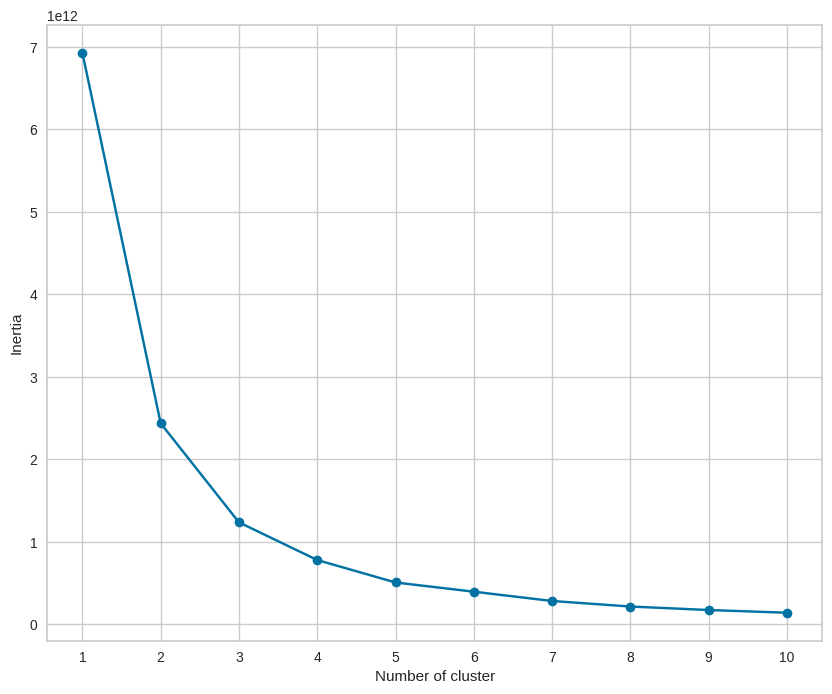

In [115]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1, max_clusters), inertia, marker='o')
plt.xlabel('Number of cluster')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, max_clusters))
plt.show()

In [116]:
# create cluster
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init=n_cluster)
kmeans.fit(df_cluster)
df_cluster['cluster'] = kmeans.labels_

In [117]:
#
df_cluster['cluster'] = kmeans.labels_
df_cluster.head()

,count_transaction,total_qty,TotalAmount,cluster
0,17,60,623300,3
1,13,57,392300,0
2,15,56,446200,0
3,10,46,302500,1
4,7,27,268600,1


<Figure size 600x600 with 0 Axes>

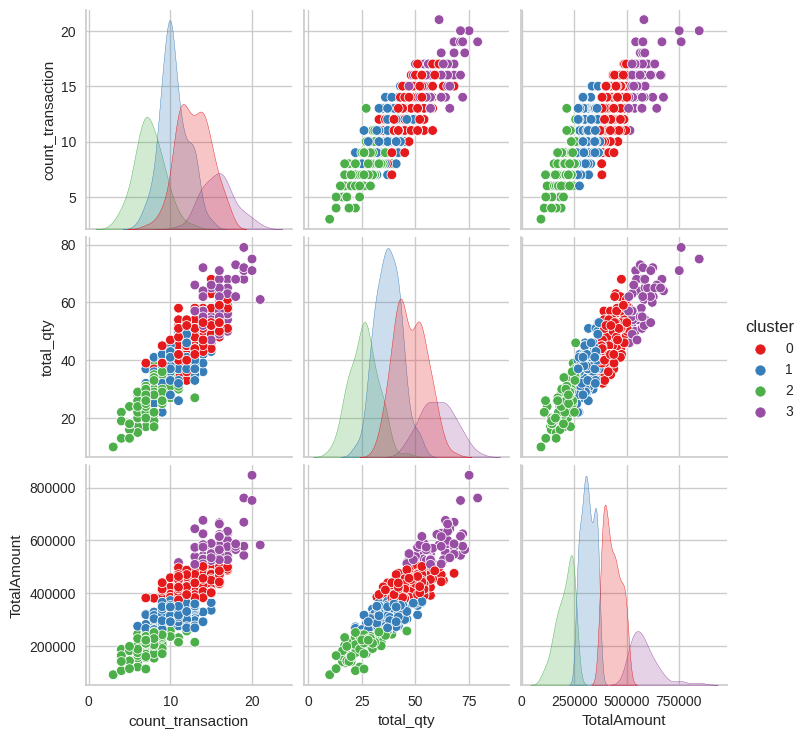

In [119]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set1')
plt.show()

In [120]:
df_cluster_mean = df_cluster.groupby('cluster').agg({'count_transaction':'mean','total_qty':'mean','TotalAmount':'mean'})
df_cluster_mean.sort_values('cluster', ascending = False)

,count_transaction,total_qty,TotalAmount
cluster,,,
3,15.877193,60.421053,583240.350877
2,7.448980,25.867347,206380.612245
1,10.414474,37.263158,316792.763158
0,12.871429,47.521429,431575.000000


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Product Name    5020 non-null   object        
 9   StoreName       5020 non-null   object        
 10  GroupStore      5020 non-null   object        
 11  Type            5020 non-null   object        
 12  Latitude        5020 non-null   float64       
 13  Longitude       5020 non-null   float64       
 14  Age             5020 non-null   int64         
 15  Gend

In [122]:
from google.colab import drive
drive.mount('/content/drive')

# Save the DataFrame to a CSV file
data.to_csv('/content/drive/MyDrive/Rakamin/data_join.csv', index=False, header=True)

Mounted at /content/drive
